In [1]:
# !pip install scipy
# !pip install torch
# !pip install torchvision

In [29]:
import copy
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights,MaskRCNN_ResNet50_FPN_V2_Weights
# from torchvision.models.quantization import ResNet50_QuantizedWeights
# from torchvision.utils import make_grid
# from torchvision.io import read_image
from pathlib import Path
# from torchvision.utils import draw_bounding_boxes
# from torchvision.utils import draw_segmentation_masks
# from torchvision.utils import make_grid
# from torchvision.io import read_image
# from pathlib import Path

# import stereo_image_utils

In [31]:
# here are some helper functions
# load image from file
# preprocess image for input into mask rcnn model
# display image
# display image pair, to display two images

'''
  # img: This represents the image data loaded from the file using cv2.imread in the previous step.
  # cv2.cvtColor(img, cv2.COLOR_BGR2RGB): This applies OpenCV's cv2.cvtColor function to convert the
     color space of the image stored in img from BGR
     (Blue, Green, Red - OpenCV's default format) to RGB (Red, Green, Blue) format.
'''

def load_img(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

def display_image(image):
    fig, axes = plt.subplots(figsize=(12, 8))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(image)

    plt.show()


def display_image_pair(first_image, second_image):
    # this funciton from Computer vision course notes
    # When using plt.subplots, we can specify how many plottable regions we want to create through nrows and ncols
    # Here we are creating a subplot with 2 columns and 1 row (i.e. side-by-side axes)
    # When we do this, axes becomes a list of length 2 (Containing both plottable axes)

    '''
      # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8)) creates a figure (fig) and a list of axes (axes) using Matplotlib's plt.subplots.
      # nrows=1 specifies one row of subplots.
      # ncols=2 specifies two columns of subplots, which means the images will be displayed side-by-side.
      # figsize=(12, 8) sets the size of the figure in inches.
    '''

    '''
      # fig represents the entire visualization window.
      # axes is a list containing individual plotting areas (subplots) within the figure. The number of elements in the list corresponds to the number of subplots created.
      # Together, fig and axes provide the foundation for creating your visualization using Matplotlib.
    '''

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

    # TODO: Call imshow on each of the axes with the first and second images
    # Make sure you handle both RGB and grayscale images

    '''
      # Checking Image Dimension:

      # if first_image.ndim == 2:: This condition checks the number of dimensions (ndim) of the image.
      # If the image has two dimensions (ndim == 2), it indicates a grayscale image.
    '''

    # axes[0].imshow(first_image): This displays the first_image on the first subplot (axes[0]) using Matplotlib's imshow function.
    # cmap='gray': This argument specifies the colormap to be used for displaying the grayscale image. A grayscale colormap is appropriate for images that only have intensity values.
    # vmin=0 and vmax=255: These arguments set the minimum and maximum intensity values for the colormap. In this case, they ensure the grayscale values range from black (0) to white (255).

    if first_image.ndim == 2:
       axes[0].imshow(first_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[0].imshow(first_image)

    if second_image.ndim == 2:
        axes[1].imshow(second_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[1].imshow(second_image)

    plt.show()

In [32]:
# these colours are used to draw boxes.

COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

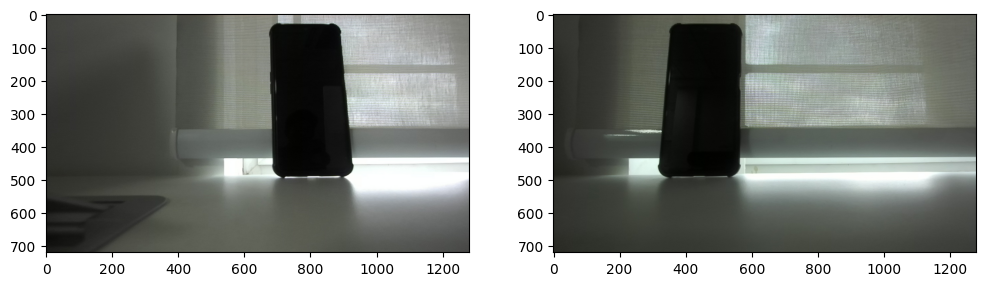

(720, 1280, 3)


In [36]:
# path = 'StereoCameraImages/2Images/'

# left_eye = path + 'left_eye_' + d_calib + '.jpg' #'left_eye_demo2.jpg'
# right_eye = path + 'right_eye_' + d_calib + '.jpg' #'right_eye_demo2.jpg'

path = 'StereoCameraImages/'

left_eye = path + 'LeftImages/left_image_167cm' + '.jpg' #'left_eye_demo2.jpg'
right_eye = path + 'RightImages/right_image_167cm' + '.jpg' #'right_eye_demo2.jpg'

left_img = load_img(left_eye)
# left_img = cv2.resize(left_img, dsize=(sz1,sz2), interpolation=cv2.INTER_LINEAR)

right_img = load_img(right_eye)
# right_img = cv2.resize(right_img, dsize=(sz1,sz2), interpolation=cv2.INTER_LINEAR)

'''
  # img.shape returns a tuple containing the image dimensions.
  # [1] accesses the second element in the tuple, which corresponds to the width.
  # [0] accesses the first element, which corresponds to the height
'''

sz1 ,sz2 = right_img.shape[1], right_img.shape[0]

display_image_pair(left_img, right_img)

imgs = [left_img, right_img]

left_right = [preprocess_image(d).squeeze(dim=0) for d in imgs]

print(right_img.shape)

In [37]:
# we use the default weights and set up the model
'''
weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)

_ = model.eval()
'''

'\nweights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT\nmodel = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)\n\n_ = model.eval()\n'

In [38]:
# import torch

# # Assuming your model is already created and in evaluation mode (as in your previous code)
# # model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
# model.eval()

# # Specify the path to save the model (replace with your desired location)
# save_path = "/MaskrCNN_model.pt"

# # Save the model
# torch.save(model.state_dict(), save_path)

In [39]:
# we use the default weights and set up the model
import torch

weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)

# Specify the path to save the model (replace with your desired location)
save_path = "MaskrCNN_model.pt"

# Save the model
torch.save(model.state_dict(), save_path)
_ = model.eval()

In [40]:
save_path = "MaskrCNN_model.pt"
model.load_state_dict(torch.load(save_path))
# Set the model to evaluation mode
_=model.eval()

In [41]:
# this functions returns the detections
# det is the boxes, top left and bottom right cooridinates
# lbls are the class labels
# scores are the confidence. We use 0.5 as default
# masks are the segmentation masks.

def get_detections(maskrcnn, imgs, score_threshold=0.5): #person, dog, elephan, zebra, giraffe, toilet
    ''' Runs maskrcnn over all frames in vid, storing the detections '''
    # Record how long the video is (in frames)
    det = []
    lbls = []
    scores = []
    masks = []

    for img in imgs:
        with torch.no_grad():
            result = maskrcnn(preprocess_image(img))[0]
            '''
              result = maskrcnn(preprocess_image(img))[0]: This line passes the preprocessed image (preprocess_image(img))
              through the Mask R-CNN model (maskrcnn). The [0] indexing extracts the first element of the returned result,
              which likely contains the model's predictions.
            '''

        mask = result["scores"] > score_threshold
        # print(result)
        print(mask)
        '''
          mask = result["scores"] > score_threshold: This line creates a mask that filters the detections based on their
          confidence scores (result["scores"]). Only detections with scores higher than the specified
          score_threshold (default 0.5) are kept.
        '''

        # boxes = result["boxes"][mask].detach().cpu().numpy()
        # det.append(boxes)

        '''
          # The line boxes = result["boxes"][mask].detach().cpu().numpy() in the get_detections function extracts the
          bounding boxes for the detections that pass the confidence score threshold. Here's a detailed breakdown:
        '''
        # list["columName"]["condiction"]
        det.append(result["boxes"][mask].detach().cpu().numpy())
        lbls.append(result["labels"][mask].detach().cpu().numpy())
        scores.append(result["scores"][mask].detach().cpu().numpy())
        masks.append(result["masks"][mask]) #I want this as a tensor
        # masks.append(result["masks"][mask].detach().cpu().numpy())
        # det is bounding boxes, lbls is class labels, scores are confidences and masks are segmentation masks

        
    print(lbls)
    return det, lbls, scores, masks

#det[0] are the bounding boxes in the left image
#det[1] are the bounding boxes in the right image

In [42]:
det, lbls, scores, masks = get_detections(model,imgs)

tensor([ True,  True, False, False, False, False, False])
tensor([ True, False, False, False, False, False, False, False])
[array([77, 76], dtype=int64), array([77], dtype=int64)]


In [43]:
print(np.array(weights.meta["categories"])[lbls[0]])
print(np.array(weights.meta["categories"])[lbls[1]])

['cell phone' 'keyboard']
['cell phone']


In [44]:
#draws the bounding boxes
def draw_detections(img, det, colours=COLOURS, obj_order = None):
  # i starts from 0, len(det), (tlx, tly, brx, bry) are postion
    for i, (tlx, tly, brx, bry) in enumerate(det):
        if obj_order is not None and len(obj_order) < i:
            i = obj_order[i]
        i %= len(colours)
        c = colours[i]
        # cv2.rectangle() use to draw the rectangle for img
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)


#annotate the class labels
def annotate_class(img, det, lbls, conf=None, colours=COLOURS, class_map=weights.meta["categories"]):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[lbls[i]]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1

        # again drawing the rectangle with filled color inside
        cv2.rectangle(img,
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)

        # writing the text that is lable in side filled rectangle in white color text
        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)


def draw_instance_segmentation_mask(img, masks):
    ''' Draws segmentation masks over an img '''
    seg_colours = np.zeros_like(img, dtype=np.uint8)
    for i, mask in enumerate(masks):
        col = (mask[0, :, :, None] * COLOURS[i])
        seg_colours = np.maximum(seg_colours, col.astype(np.uint8))
    cv2.addWeighted(img, 0.75, seg_colours, 0.75, 1.0, dst=img)



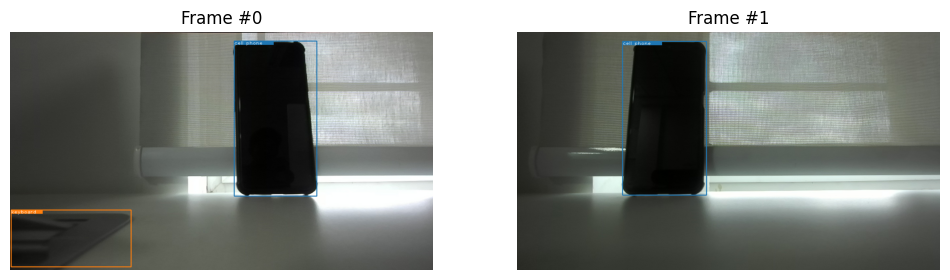

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# imgs1 = imgs.copy()

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti)
    masksi = masks[i].detach().cpu().numpy()
    # print(masksi)
    annotate_class(img,deti,lbls[i])
    # draw_instance_segmentation_mask(img, masksi)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')

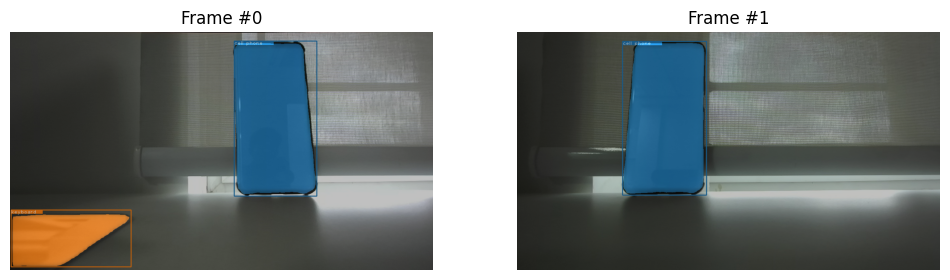

In [46]:
#draw with masks
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# imgs2 = imgs.copy()

for i, imgi in enumerate(imgs):
    img = imgi.copy()

    deti = det[i].astype(np.int32)
    draw_detections(img,deti)
    masks[i][masks[i]<0.7]=0
    masksi = masks[i].detach().cpu().numpy()
    annotate_class(img,deti,lbls[i])
    draw_instance_segmentation_mask(img, masksi)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')

In [47]:
#get centr, top left and bottom right of boxes

def tlbr_to_center1(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+brx)/2
        cy = (tly+bry)/2
        points.append([cx, cy])
    return points

def tlbr_to_corner(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+tlx)/2
        cy = (tly+tly)/2
        points.append((cx, cy))
    return points

def tlbr_to_corner_br(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx+brx)/2
        cy = (bry+bry)/2
        points.append((cx, cy))
    return points

def tlbr_to_area(boxes):
    areas = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx-tlx)
        cy = (bry-tly)
        areas.append(abs(cx*cy))
    return areas



In [48]:
'''
    # [[159.40157   27.520174 241.03233  226.7395  ]
    # [  0.         0.       112.57273  157.12044 ]
    # [240.61845  168.571    270.16025  219.13237 ]]


    # it in the form of[[Tx1,Ty1,Bx1,By1],[Tx2,Ty2,Bx2,By2],[Tx3,Ty3,Bx3,By3]]
    # where Tx : top x-axis position
    # where Ty : top y-axis position
    # where Bx : bottom x-axis position
    # where By : bottom y-axis position
    # where the 1,2,3...n are the n number item detected

'''
print(det[0],("\n")*3)
print(tlbr_to_center1(det[0]),"\n\n\n")
print(np.array(tlbr_to_center1(det[0])),"\n\n\n")
print(np.array(tlbr_to_center1(det[0]))[:,0])
# this gives the center point position of x-axis of each item detected
# [200.21694946  56.28636551 255.38934326]

[[678.66876    27.978481  928.9869    496.63025  ]
 [  3.4691339 538.2297    366.90958   710.59424  ]] 



[[803.8278198242188, 262.3043518066406], [185.18936157226562, 624.4119873046875]] 



[[803.82781982 262.30435181]
 [185.18936157 624.4119873 ]] 



[803.82781982 185.18936157]


In [49]:
#get all distances from every object box to every other object box
#left image is boxes[0]
#right image is boxes[1]

#do broad casting.
#in python, col vector - row vector gives matrix:
# [a] - [c,d] = [a-c, a-d]
# [b]           [b-c, b-d]

def get_horiz_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_tl(boxes):
    pnts1 = np.array(tlbr_to_corner(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_br(boxes):
    pnts1 = np.array(tlbr_to_corner_br(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner_br(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_vertic_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,1]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,1]
    return pnts1[:,None] - pnts2[None]

def get_area_diffs(boxes):
    pnts1 = np.array(tlbr_to_area(boxes[0]))
    pnts2 = np.array(tlbr_to_area(boxes[1]))
    return abs(pnts1[:,None] - pnts2[None])


In [50]:
## get distance bentween corner and centre

centre = sz1/2

def get_dist_to_centre_tl(box, cntr = centre):
    pnts = np.array(tlbr_to_corner(box))[:,0]
    return abs(pnts - cntr)


def get_dist_to_centre_br(box, cntr = centre):
    pnts = np.array(tlbr_to_corner_br(box))[:,0]
    return abs(pnts - cntr)



In [51]:
tmp1 = get_dist_to_centre_br(det[0])
tmp2 = get_dist_to_centre_br(det[1])
print(tmp1)
print(tmp2)

[288.98687744 273.09042358]
[66.00738525]


In [52]:
# create the tracking cost function.
# consists of theree parts.
#  1. The vertical move up and down of object centre of mass. Scale this up because we do not expect this to be very much.
#  2. The move left or right by the object. We only expect it to move right (from the left eye image). So penalise if it moves left.
#  3. The difference in area of pixels. Area of image is width x height, so divide by height, there for this will have max value of width

def get_cost(boxes, lbls = None, sz1 = 400):
    alpha = sz1; beta  = 10; gamma = 5

    #vertical_dist, scale by gamma since can't move up or down
    vert_dist = gamma*abs(get_vertic_dist_centre(boxes))

    #horizonatl distance.
    horiz_dist = get_horiz_dist_centre(boxes)

    #increase cost if object has moved from right to left.
    horiz_dist[horiz_dist<0] = beta*abs(horiz_dist[horiz_dist<0])

    #area of box
    area_diffs = get_area_diffs(boxes)/alpha

    cost = np.array([vert_dist,horiz_dist,area_diffs])

    cost=cost.sum(axis=0)

    #add penalty term for different object classes
    if lbls is not None:
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                if (lbls[0][i]!=lbls[1][j]):
                    cost[i,j]+=150
    return cost



In [53]:
def get_cost_with_com(masks, lbls = None,prob_thresh = 0.7):
    alpha = 240; beta  = 10; gamma = 5

    #left masks
    mask_bool = masks[0] > prob_thresh
    mask_bool = mask_bool.squeeze(1)
    #right masks
    mask_bool2 = masks[1] > prob_thresh
    mask_bool2 = mask_bool2.squeeze(1)

    #left params
    #com1 is center of mass of height
    #com2 is center of mass of width
    mask_size = (mask_bool).sum(dim=[1,2])
    mask_com_matrix_1 = torch.tensor(range(mask_bool.shape[1]))
    com1 = ((mask_com_matrix_1.unsqueeze(1))*mask_bool).sum(dim=[1,2])/mask_size
    mask_com_matrix_2 = torch.tensor(range(mask_bool.shape[2]))
    com2 = ((mask_com_matrix_2.unsqueeze(0))*mask_bool).sum(dim=[1,2])/mask_size

    left_params = torch.stack((com1, com2, mask_size)).transpose(1,0)

    #get right params
    mask_size2 = (mask_bool2).sum(dim=[1,2])
    mask_com_matrix_12 = torch.tensor(range(mask_bool2.shape[1]))
    com12 = ((mask_com_matrix_12.unsqueeze(1))*mask_bool2).sum(dim=[1,2])/mask_size2
    mask_com_matrix_22 = torch.tensor(range(mask_bool2.shape[2]))
    com22 = ((mask_com_matrix_22.unsqueeze(0))*mask_bool2).sum(dim=[1,2])/mask_size2

    right_params = torch.stack((com12, com22, mask_size2)).transpose(1,0)

    #calculate cost function
    cost = (left_params[:,None] - right_params[None])
    #scale counts
    cost[:,:,2]=abs(cost[:,:,2])/alpha

    #can't move right, can only move left
    cost[cost[:,:,1]<0] = beta*abs(cost[cost[:,:,1]<0])

    #move up and down, take abs vals
    cost[:,:,0] = gamma*abs(cost[:,:,0])
    # print(cost.shape)
    cost = cost.sum(dim=2)
    if lbls is not None:
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                if (lbls[0][i]!=lbls[1][j]):
                    cost[i,j]+=100
                    # print(lbls[0][i], lbls[1][j])
    return cost


def get_horiz_dist(masks, prob_thresh = 0.7):
    # gets the horizontal distance between the centre of mass for each object
    #left masks
    mask_bool = masks[0] > prob_thresh
    mask_bool = mask_bool.squeeze(1)
    #right masks
    mask_bool2 = masks[1] > prob_thresh
    mask_bool2 = mask_bool2.squeeze(1)

    #left params
    #com1 is center of mass of height
    #com2 is center of mass of width
    mask_size = (mask_bool).sum(dim=[1,2])
    mask_com_matrix_1 = torch.tensor(range(mask_bool.shape[1]))
    com1 = ((mask_com_matrix_1.unsqueeze(1))*mask_bool).sum(dim=[1,2])/mask_size
    mask_com_matrix_2 = torch.tensor(range(mask_bool.shape[2]))
    com2 = ((mask_com_matrix_2.unsqueeze(0))*mask_bool).sum(dim=[1,2])/mask_size

    left_params = torch.stack((com1, com2, mask_size)).transpose(1,0)

    #get right params
    mask_size2 = (mask_bool2).sum(dim=[1,2])
    mask_com_matrix_12 = torch.tensor(range(mask_bool2.shape[1]))
    com12 = ((mask_com_matrix_12.unsqueeze(1))*mask_bool2).sum(dim=[1,2])/mask_size2
    mask_com_matrix_22 = torch.tensor(range(mask_bool2.shape[2]))
    com22 = ((mask_com_matrix_22.unsqueeze(0))*mask_bool2).sum(dim=[1,2])/mask_size2

    right_params = torch.stack((com12, com22, mask_size2)).transpose(1,0)

    #calculate cost function
    cost = (left_params[:,None] - right_params[None])
    return cost[:,:,1]

In [54]:
def get_tracks(cost):
    return scipy.optimize.linear_sum_assignment(cost)


def get_tracks_ij(cost):
    tracks = scipy.optimize.linear_sum_assignment(cost)
    return [[i,j] for i, j in zip(*tracks)]



In [55]:
cost = get_cost(det, lbls = lbls)

In [56]:
tracks = scipy.optimize.linear_sum_assignment(cost)
print(tracks)

h_d = [[np.array(weights.meta["categories"])[lbls[0]][i],np.array(weights.meta["categories"])[lbls[1]][j]] for i, j in zip(*tracks)]
print(np.array(weights.meta["categories"])[lbls[0]])
print(h_d)

(array([0], dtype=int64), array([0], dtype=int64))
['cell phone' 'keyboard']
[['cell phone', 'cell phone']]


In [57]:
#we take the corner that is closest to the centre. This is because the other corner might be going off the image.

dists_tl =  get_horiz_dist_corner_tl(det)
dists_br =  get_horiz_dist_corner_br(det)

final_dists = []
dctl = get_dist_to_centre_tl(det[0])
dcbr = get_dist_to_centre_br(det[0])

for i, j in zip(*tracks):
    if dctl[i] < dcbr[i]:
        final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))

    else:
        final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))


final_dists

[(358.7649841308594, 'cell phone')]

In [58]:
#get focal length
# for 28.20cm away bottle image, we had 227.710 pixels between bottle boxes
# and for 16.7cm away bottle image we had 68.75 pixels between left and right bottles
fl = 16.7-227.710*28.20/358.438
print(fl)

-1.2150145910868844


In [59]:
#calibrate theta. cameras are 7.05 cms apart
tantheta = (1/(28.2-fl))*(7.05/2)*sz1/227.710
print(tantheta)

0.673624570232178


In [60]:
#final distances as list
fd = [i for (i,j) in final_dists]
print(fd)

[358.7649841308594]


In [61]:
#find the distance away
dists_away = (7.05/2)*sz1*(1/tantheta)/np.array(fd)+fl

In [62]:
cat_dist = []
for i in range(len(dists_away)):
    cat_dist.append(f'{np.array(weights.meta["categories"])[lbls[0]][i]} {dists_away[i]:.1f}cm')
    print(f'{np.array(weights.meta["categories"])[lbls[0]][i]} is {dists_away[i]:.1f}cm away')

cell phone is 17.5cm away


In [63]:
#annotate the class labels
def annotate_class2(img, det, lbls,class_map, conf=None,  colours=COLOURS):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[i]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1

        cv2.rectangle(img,
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)

        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)

In [64]:
list(np.array(cat_dist)[(tracks[0])])

['cell phone 17.5cm']

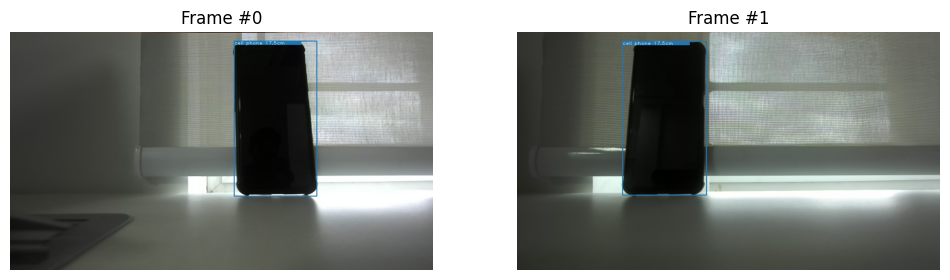

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

t1 = [list(tracks[1]), list(tracks[0])]
eye=['LeftOutput','RightOutput']
import cv2
for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti[list(tracks[i])], obj_order=list(t1[i]))
    annotate_class2(img,deti[list(tracks[i])],lbls[i][list(tracks[i])],cat_dist)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')
    cv2.imwrite(f"{eye[i]}/save167m.jpg",img)
